In [1]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import _datetime
import json
import seaborn as sns
import dateutil.parser as dp

from datetime import datetime
from json import dumps
from dateutil import parser
from dateutil.relativedelta import relativedelta

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders
from scipy.optimize import curve_fit

# Ignore harmless jupyter warnings
import warnings
warnings.filterwarnings("ignore")

In [12]:
# Set date variables
end_date = datetime.now()
print(end_date)
start_date = datetime.now() - relativedelta(months=60)


def myconverter(o):
    if isinstance(o, datetime):
        return "{}-{}-{}".format(o.year, o.month, o.day)
    
#convert the string formatted date
end_date_1 = _datetime.datetime.strptime(myconverter(end_date), '%Y-%m-%d').date()
print(end_date_1)
start_date_1 = _datetime.datetime.strptime(myconverter(start_date), '%Y-%m-%d').date()
print(start_date_1)

# Load datasets

df = pd.read_json(f'https://api.coindesk.com/v1/bpi/historical/close/USD.json?start={start_date_1}&end={end_date_1}')
df.index.freq = 'D'

unix_start = datetime.timestamp(start_date)
print('timestamp =', unix_start)
unix_end = datetime.timestamp(end_date)
print('timestamp =', unix_end)
url = f'https://api.coingecko.com/api/v3/coins/ethereum/market_chart/range?vs_currency=usd&from={unix_start}&to={unix_end}'
dfe = pd.read_csv(url)
dfe = pd.DataFrame.from_dict(dfe, orient='index')

2021-04-14 11:58:41.412294
2021-04-14
2016-04-14
timestamp = 1460660321.413294
timestamp = 1618426721.412294


In [13]:
dfe

,"{""prices"":[[1460678400000",8.20613745870167],[1460764800000,8.555981966976974],[1460851200000,9.323170276346234],[1460937600000,8.960482405053712],[1461024000000,8.696773038727313],...,[1618012800000.2,25076796421.07279],[1618099200000.2,32243242817.777157],[1618185600000.2,25369863410.044476],[1618272000000.2,29096213677.73583],[1618358400000.2,35760747636.05728]]}


In [15]:
dfe_1 = pd.DataFrame(list(dfe.items()))
dfe_1 = dfe_1.rename(columns={0: 'date', 1: 'todrop'})
dfe_1.head()

,date,todrop
0,"{""prices"":[[1460678400000","Series([], Name: {""prices"":[[1460678400000, dt..."
1,8.20613745870167],"Series([], Name: 8.20613745870167], dtype: obj..."
2,[1460764800000,"Series([], Name: [1460764800000, dtype: object)"
3,8.555981966976974],"Series([], Name: 8.555981966976974], dtype: ob..."
4,[1460851200000,"Series([], Name: [1460851200000, dtype: object)"


In [16]:
dfe_1 = dfe_1.drop(columns = ['todrop'])
dfe_1.head()

,date
0,"{""prices"":[[1460678400000"
1,8.20613745870167]
2,[1460764800000
3,8.555981966976974]
4,[1460851200000


In [17]:
pd.set_option('display.max_row', None)
dfe_1['date'].head()

0    {"prices":[[1460678400000
1            8.20613745870167]
2               [1460764800000
3           8.555981966976974]
4               [1460851200000
Name: date, dtype: object

In [18]:
dfe_1_price = dfe_1.iloc[:3653]
dfe_1_price = dfe_1_price.reset_index(drop=True)
dfe_1_mktcp = dfe_1.iloc[3653:7302]
dfe_1_mktcp = dfe_1_mktcp.reset_index(drop=True)
dfe_1_totvol = dfe_1.iloc[7302:]
dfe_1_totvol = dfe_1_totvol.reset_index(drop=True)
dfe_1_price.head()

,date
0,"{""prices"":[[1460678400000"
1,8.20613745870167]
2,[1460764800000
3,8.555981966976974]
4,[1460851200000


In [20]:
dfe_1_totvol.head()

,date
0,total_volumes:[[1460678400000
1,11510142.230195371]
2,[1460764800000.2
3,9164981.891612116]
4,[1460851200000.2


In [21]:
def column_parser(df):
    epi = []
    epi = df[1::2]
    return epi;

def date_parser(df):
    date_df = []
    date_df = df[::2]
    return date_df;

In [24]:
epi = column_parser(dfe_1_price)
epi = epi.rename(columns={'date':'epi'})
mktcp = column_parser(dfe_1_mktcp)
mktcp = mktcp.rename(columns={'date':'ETH Mkt Cap'})
totvol = column_parser(dfe_1_totvol)
totvol = totvol.rename(columns={'date':'ETH Total Vol'})
date_df = date_parser(dfe_1_price)

In [25]:
epi.head()

,epi
1,8.20613745870167]
3,8.555981966976974]
5,9.323170276346234]
7,8.960482405053712]
9,8.696773038727313]


In [26]:
epi.tail()

,epi
3643,2069.6677960855295]
3645,2142.7960653929085]
3647,2150.2651427927744]
3649,2142.476275865736]
3651,2304.3435163110134]]


In [27]:
epi['epi'] = epi['epi'].map(lambda x: x.rstrip(']'))
mktcp['ETH Mkt Cap'] = mktcp['ETH Mkt Cap'].map(lambda x: x.rstrip(']'))
totvol['ETH Total Vol'] = totvol['ETH Total Vol'].map(lambda x: x.rstrip(']}'))
date_df['date'] = date_df['date'].map(lambda x: x.rstrip('{"prices":['))

In [28]:
epi.head()

,epi
1,8.20613745870167
3,8.555981966976974
5,9.323170276346234
7,8.960482405053712
9,8.696773038727313


In [29]:
len(epi)

1826

In [30]:
epi.reset_index(inplace = True)
epi = epi.drop(columns=['index'])
epi

,epi
0,8.20613745870167
1,8.555981966976974
2,9.323170276346234
3,8.960482405053712
4,8.696773038727313
5,8.484150722584234
6,8.11104074507033
7,7.855106665179344
8,8.377192623957283
9,7.995361207240304


In [31]:
mktcp.reset_index(inplace = True)
mktcp = mktcp.drop(columns=['index'])
totvol.reset_index(inplace = True)
totvol = totvol.drop(columns=['index'])
date_df.reset_index(inplace = True)
date_df = date_df.drop(columns=['index'])

In [32]:
df.tail()

,bpi,disclaimer,time
2021-04-11,59990.8733,This data was produced from the CoinDesk Bitco...,NaN
2021-04-12,59856.7133,This data was produced from the CoinDesk Bitco...,NaN
2021-04-13,63564.8333,This data was produced from the CoinDesk Bitco...,NaN
updated,NaN,This data was produced from the CoinDesk Bitco...,"Apr 14, 2021 18:58:42 UTC"
updatedISO,NaN,This data was produced from the CoinDesk Bitco...,2021-04-14T18:58:42+00:00


In [34]:
df1 = df.drop(columns=['time','disclaimer'])
df1.drop(df1.tail(2).index,inplace=True)
df1.tail()

,bpi
2021-04-09,58119.5900
2021-04-10,59791.8450
2021-04-11,59990.8733
2021-04-12,59856.7133
2021-04-13,63564.8333


In [35]:
len(df1)

1826

In [36]:
df1.tail(20)

,bpi
2021-03-25,51344.2750
2021-03-26,55046.0300
2021-03-27,55853.7717
2021-03-28,55777.2867
2021-03-29,57641.5567
2021-03-30,58795.9467
2021-03-31,58793.8417
2021-04-01,58726.6833
2021-04-02,58981.1117
2021-04-03,57065.3800


In [38]:
df1.index = pd.to_datetime(df1.index)
df1['date'] = df1.index
epi['date'] = pd.to_datetime(df1.index)
len(df1)

1826

In [39]:
for day in df1['date']:
    df1['date'][day] += relativedelta(days=7)
    print(df1['date'][day])

2016-04-21 00:00:00
2016-04-22 00:00:00
2016-04-23 00:00:00
2016-04-24 00:00:00
2016-04-25 00:00:00
2016-04-26 00:00:00
2016-04-27 00:00:00
2016-04-28 00:00:00
2016-04-29 00:00:00
2016-04-30 00:00:00
2016-05-01 00:00:00
2016-05-02 00:00:00
2016-05-03 00:00:00
2016-05-04 00:00:00
2016-05-05 00:00:00
2016-05-06 00:00:00
2016-05-07 00:00:00
2016-05-08 00:00:00
2016-05-09 00:00:00
2016-05-10 00:00:00
2016-05-11 00:00:00
2016-05-12 00:00:00
2016-05-13 00:00:00
2016-05-14 00:00:00
2016-05-15 00:00:00
2016-05-16 00:00:00
2016-05-17 00:00:00
2016-05-18 00:00:00
2016-05-19 00:00:00
2016-05-20 00:00:00
2016-05-21 00:00:00
2016-05-22 00:00:00
2016-05-23 00:00:00
2016-05-24 00:00:00
2016-05-25 00:00:00
2016-05-26 00:00:00
2016-05-27 00:00:00
2016-05-28 00:00:00
2016-05-29 00:00:00
2016-05-30 00:00:00
2016-05-31 00:00:00
2016-06-01 00:00:00
2016-06-02 00:00:00
2016-06-03 00:00:00
2016-06-04 00:00:00
2016-06-05 00:00:00
2016-06-06 00:00:00
2016-06-07 00:00:00
2016-06-08 00:00:00
2016-06-09 00:00:00


2018-02-15 00:00:00
2018-02-16 00:00:00
2018-02-17 00:00:00
2018-02-18 00:00:00
2018-02-19 00:00:00
2018-02-20 00:00:00
2018-02-21 00:00:00
2018-02-22 00:00:00
2018-02-23 00:00:00
2018-02-24 00:00:00
2018-02-25 00:00:00
2018-02-26 00:00:00
2018-02-27 00:00:00
2018-02-28 00:00:00
2018-03-01 00:00:00
2018-03-02 00:00:00
2018-03-03 00:00:00
2018-03-04 00:00:00
2018-03-05 00:00:00
2018-03-06 00:00:00
2018-03-07 00:00:00
2018-03-08 00:00:00
2018-03-09 00:00:00
2018-03-10 00:00:00
2018-03-11 00:00:00
2018-03-12 00:00:00
2018-03-13 00:00:00
2018-03-14 00:00:00
2018-03-15 00:00:00
2018-03-16 00:00:00
2018-03-17 00:00:00
2018-03-18 00:00:00
2018-03-19 00:00:00
2018-03-20 00:00:00
2018-03-21 00:00:00
2018-03-22 00:00:00
2018-03-23 00:00:00
2018-03-24 00:00:00
2018-03-25 00:00:00
2018-03-26 00:00:00
2018-03-27 00:00:00
2018-03-28 00:00:00
2018-03-29 00:00:00
2018-03-30 00:00:00
2018-03-31 00:00:00
2018-04-01 00:00:00
2018-04-02 00:00:00
2018-04-03 00:00:00
2018-04-04 00:00:00
2018-04-05 00:00:00


2019-12-17 00:00:00
2019-12-18 00:00:00
2019-12-19 00:00:00
2019-12-20 00:00:00
2019-12-21 00:00:00
2019-12-22 00:00:00
2019-12-23 00:00:00
2019-12-24 00:00:00
2019-12-25 00:00:00
2019-12-26 00:00:00
2019-12-27 00:00:00
2019-12-28 00:00:00
2019-12-29 00:00:00
2019-12-30 00:00:00
2019-12-31 00:00:00
2020-01-01 00:00:00
2020-01-02 00:00:00
2020-01-03 00:00:00
2020-01-04 00:00:00
2020-01-05 00:00:00
2020-01-06 00:00:00
2020-01-07 00:00:00
2020-01-08 00:00:00
2020-01-09 00:00:00
2020-01-10 00:00:00
2020-01-11 00:00:00
2020-01-12 00:00:00
2020-01-13 00:00:00
2020-01-14 00:00:00
2020-01-15 00:00:00
2020-01-16 00:00:00
2020-01-17 00:00:00
2020-01-18 00:00:00
2020-01-19 00:00:00
2020-01-20 00:00:00
2020-01-21 00:00:00
2020-01-22 00:00:00
2020-01-23 00:00:00
2020-01-24 00:00:00
2020-01-25 00:00:00
2020-01-26 00:00:00
2020-01-27 00:00:00
2020-01-28 00:00:00
2020-01-29 00:00:00
2020-01-30 00:00:00
2020-01-31 00:00:00
2020-02-01 00:00:00
2020-02-02 00:00:00
2020-02-03 00:00:00
2020-02-04 00:00:00


In [40]:
df1.head()

,bpi,date
2016-04-14,425.106,2016-04-21
2016-04-15,429.980,2016-04-22
2016-04-16,430.837,2016-04-23
2016-04-17,427.862,2016-04-24
2016-04-18,429.054,2016-04-25


In [41]:
df1.reset_index(inplace=True)
df1 = df1.drop(columns=['index'])
df1 = epi.merge(df1, how='right', on='date')
df1 = df1.reindex(columns=['date','bpi','epi'])
df1.head()

,date,bpi,epi
0,2016-04-21,425.106,7.855106665179344
1,2016-04-22,429.980,8.377192623957283
2,2016-04-23,430.837,7.995361207240304
3,2016-04-24,427.862,7.812751656077315
4,2016-04-25,429.054,7.424663266229029


In [42]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1826 entries, 0 to 1825
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1826 non-null   datetime64[ns]
 1   bpi     1826 non-null   float64       
 2   epi     1819 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 57.1+ KB


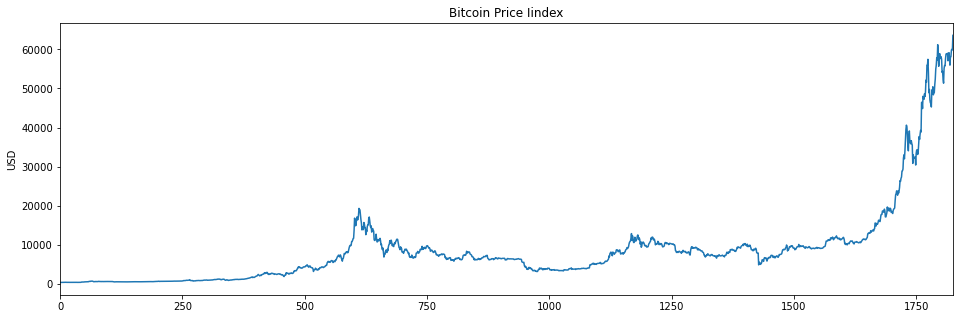

In [44]:
title = 'Bitcoin Price Iindex'
ylabel = 'USD'
xlabel = ''

ax = df1['bpi'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [45]:
df1['epi'] = df1['epi'].astype(float)

<function matplotlib.pyplot.show(close=None, block=None)>

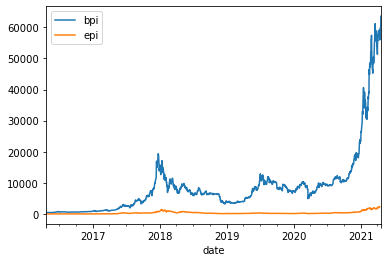

In [46]:
title='Ethereum Price Index'
ylabel='USD'
xlabel =''

lines = df1.plot.line(x='date', y=['bpi','epi'])
plt.legend()

plt.show

In [47]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC')
    
    labels = ['ADF test statistic', 'p-value', '# lags used', '# observations']
    out = pd.Series(result[0:4],index=labels)
    
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())
    
    if result[1] <= 0.05:
        print('String evidence against the null hypothesis')
        print('Reject the null hypothesis')
        print('Data has no unit root and is stationary')
    else:
        print('Weak evidence against the null hypothesis')
        print('Fail to reject the null hypothesis')
        print('Data has a unit root and is non-stationary')

In [48]:
adf_test(df1['epi'])

Augmented Dickey-Fuller Test: 
ADF test statistic         2.112346
p-value                    0.998802
# lags used               23.000000
# observations          1795.000000
critical value (1%)       -3.433998
critical value (5%)       -2.863152
critical value (10%)      -2.567628
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [49]:
df1['diff_bpi'] = np.append(np.nan, np.diff(df1['bpi']))
df1['diff_epi'] = np.append(np.nan, np.diff(df1['epi']))
df1

,date,bpi,epi,diff_bpi,diff_epi
0,2016-04-21,425.1060,7.855107,NaN,NaN
1,2016-04-22,429.9800,8.377193,4.8740,0.522086
2,2016-04-23,430.8370,7.995361,0.8570,-0.381831
3,2016-04-24,427.8620,7.812752,-2.9750,-0.182610
4,2016-04-25,429.0540,7.424663,1.1920,-0.388088
5,2016-04-26,436.1050,7.724695,7.0510,0.300031
6,2016-04-27,442.1560,7.250216,6.0510,-0.474479
7,2016-04-28,451.1020,7.475818,8.9460,0.225602
8,2016-04-29,447.6360,8.892970,-3.4660,1.417152
9,2016-04-30,452.5840,8.832454,4.9480,-0.060516


In [50]:
adf_test(df1['diff_epi'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -6.341181e+00
p-value                 2.752273e-08
# lags used             2.500000e+01
# observations          1.792000e+03
critical value (1%)    -3.434004e+00
critical value (5%)    -2.863154e+00
critical value (10%)   -2.567629e+00
String evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


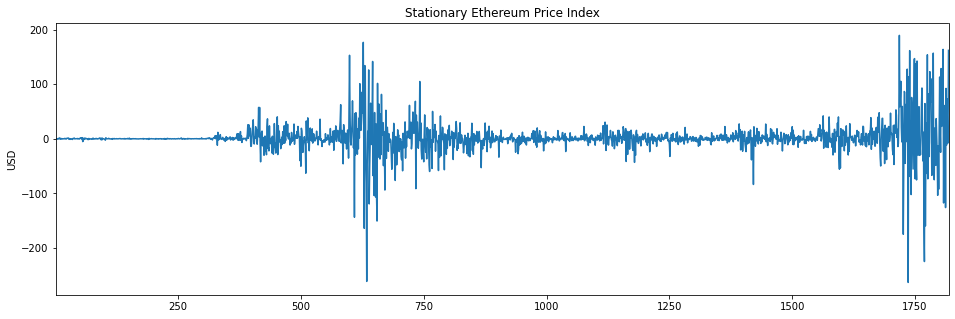

In [51]:
title = 'Stationary Ethereum Price Index'
ylabel='USD'
xlabel=''

ax= df1['diff_epi'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [52]:
df1.set_index('date', inplace=True)
df1.head()

,bpi,epi,diff_bpi,diff_epi
date,,,,
2016-04-21,425.106,7.855107,NaN,NaN
2016-04-22,429.980,8.377193,4.874,0.522086
2016-04-23,430.837,7.995361,0.857,-0.381831
2016-04-24,427.862,7.812752,-2.975,-0.182610
2016-04-25,429.054,7.424663,1.192,-0.388088


In [53]:
train = df1.iloc[:1705]
test = df1.iloc[1705:]

In [54]:
df2 = df1.dropna(subset=['epi'])

In [55]:
df2

,bpi,epi,diff_bpi,diff_epi
date,,,,
2016-04-21,425.1060,7.855107,NaN,NaN
2016-04-22,429.9800,8.377193,4.8740,0.522086
2016-04-23,430.8370,7.995361,0.8570,-0.381831
2016-04-24,427.8620,7.812752,-2.9750,-0.182610
2016-04-25,429.0540,7.424663,1.1920,-0.388088
2016-04-26,436.1050,7.724695,7.0510,0.300031
2016-04-27,442.1560,7.250216,6.0510,-0.474479
2016-04-28,451.1020,7.475818,8.9460,0.225602
2016-04-29,447.6360,8.892970,-3.4660,1.417152


In [56]:
auto_arima(df2['epi'],exogenous=df2[['bpi']], seasonal=True,m=4).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1819
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -8701.118
Date:                Wed, 14 Apr 2021   AIC                          17408.236
Time:                        12:45:17   BIC                          17424.752
Sample:                    04-21-2016   HQIC                         17414.330
                         - 04-13-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.2817      0.682      1.879      0.060      -0.055       2.619
bpi           -0.0007      0.000     -1.478      0.139      -0.002       0.000
sigma2       840.7680      8.409     99.981      0.000     824.286     857.250
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):             30634.40
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               8.51   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [70]:
model = SARIMAX(df1['epi'],exog=df1['bpi'], order=(2,1,3),seasonal_order=(2, 0, [1,2], 4), enforce_invertability=False)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                    epi   No. Observations:                 1826
Model:             SARIMAX(2, 1, 3)x(2, 0, [1, 2], 4)   Log Likelihood               -8655.602
Date:                                Wed, 14 Apr 2021   AIC                          17333.204
Time:                                        12:58:55   BIC                          17393.807
Sample:                                    04-21-2016   HQIC                         17355.560
                                         - 04-20-2021                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
bpi           -0.0014      0.000     -2.841      0.004      -0.002      -0.000
ar.L1          0.2161      0.014     15.883      0.000       0.189       0.243
ar.L2         -0.8322      0.014    -58.767      0.000      -0.860      -0.804
ma.L1         -0.2488      0.020    -12.525      0.000      -0.288      -0.210
ma.L2          0.9603      0.008    114.901      0.000       0.944       0.977
ma.L3         -0.0597      0.014     -4.291      0.000      -0.087      -0.032
ar.S.L4        0.0375      0.114      0.329      0.742      -0.186       0.261
ar.S.L8       -0.6114      0.069     -8.849      0.000      -0.747      -0.476
ma.S.L4        0.0454      0.117      0.389      0.697      -0.183       0.274
ma.S.L8        0.5788      0.074      7.799      0.000       0.433       0.724
sigma2       832.5384      9.437     88.224      0.000     814.043     851.034
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             32235.50
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               7.87   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [71]:
start=len(train)+len(test)-21
end=len(train)+len(test)-1
exog_forecast = test['bpi']
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('SARIMAX(2, 1, 3)(2, 0, [1,2], 4) Predictions')

[Text(0.5, 0, ''), Text(0, 0.5, 'USD')]

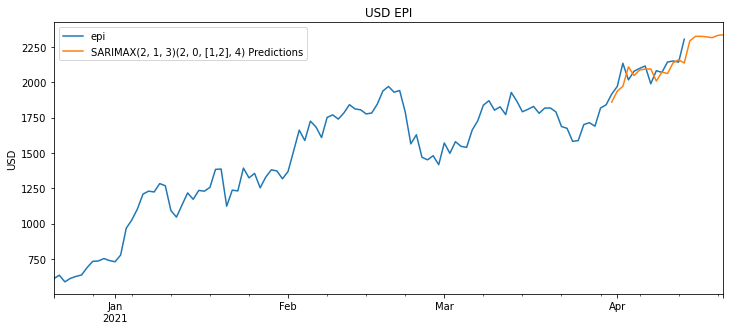

In [72]:
title='USD EPI'
ylabel='USD'
xlabel=''

ax=test['epi'].plot(legend=True,figsize=(12,5),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [73]:
predictions

2021-03-31    1859.474950
2021-04-01    1937.057872
2021-04-02    1970.906065
2021-04-03    2108.432541
2021-04-04    2047.489544
2021-04-05    2085.779411
2021-04-06    2093.303094
2021-04-07    2093.844702
2021-04-08    2008.303721
2021-04-09    2071.633960
2021-04-10    2061.447794
2021-04-11    2136.939108
2021-04-12    2159.462884
2021-04-13    2135.988645
2021-04-14    2292.334347
2021-04-15    2324.127821
2021-04-16    2324.902764
2021-04-17    2320.966648
2021-04-18    2315.045865
2021-04-19    2331.096147
2021-04-20    2335.790554
Freq: D, Name: SARIMAX(2, 1, 3)(2, 0, [1,2], 4) Predictions, dtype: float64